In [478]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
print("libs downloaded")

libs downloaded


In [479]:
#define path
file_path = "C:/Users/tyler/OneDrive - SNHU/WGU/Machine Learning/Task3/medical_clean.csv"
df = pd.read_csv(file_path)
#check out data types and if there are any null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB


In [480]:
start_date = '2014-01-01'
df['Date'] = pd.to_datetime(start_date) + pd.to_timedelta(df['Day'] - 1, unit='D')
df=df.drop(columns=['Day'])
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')
print(df.head)

<bound method NDFrame.head of               Revenue
Date                 
2014-01-01   0.000000
2014-01-02  -0.292356
2014-01-03  -0.327772
2014-01-04  -0.339987
2014-01-05  -0.124888
...               ...
2015-12-28  15.722056
2015-12-29  15.865822
2015-12-30  15.708988
2015-12-31  15.822867
2016-01-01  16.069429

[731 rows x 1 columns]>


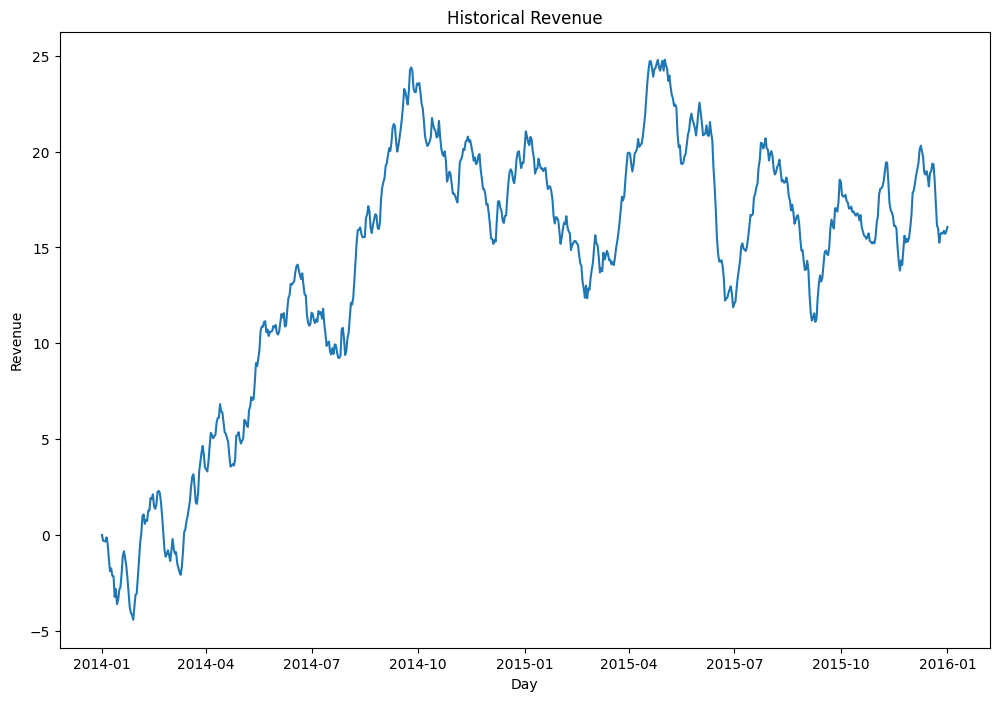

In [481]:
plt.figure(figsize=(12, 8))
# Plot the time series
plt.plot(df['Revenue'])
plt.title('Historical Revenue')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.show()

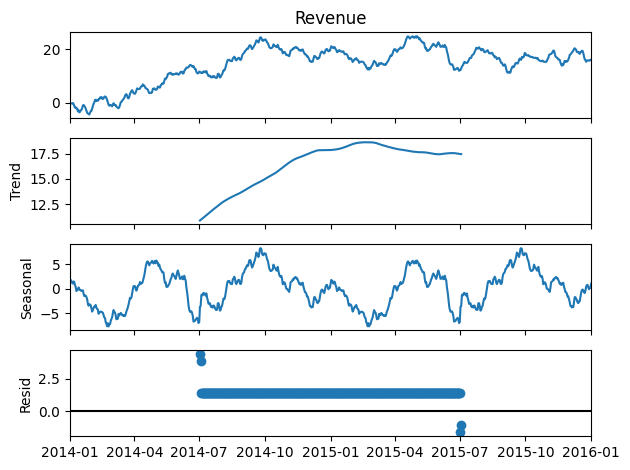

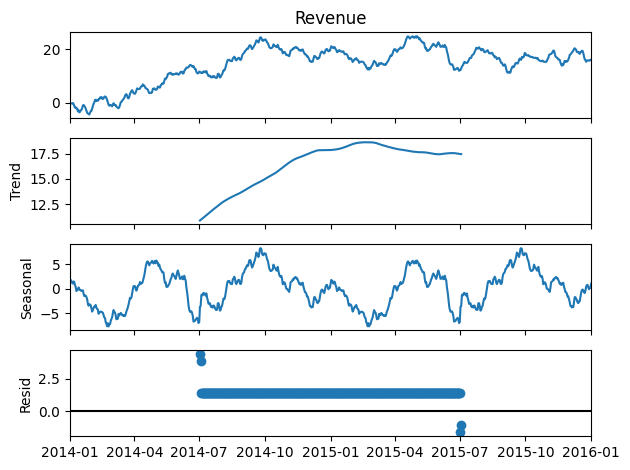

In [482]:
decomposition = seasonal_decompose(df['Revenue'], model='additive', period=365)  # for daily data
decomposition.plot()

In [483]:
#AUGMENTED DICKEY-FULLER TEST
#CHECKING FOR STATIONARITY
adf_test = adfuller(df['Revenue'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -2.218319
p-value: 0.199664


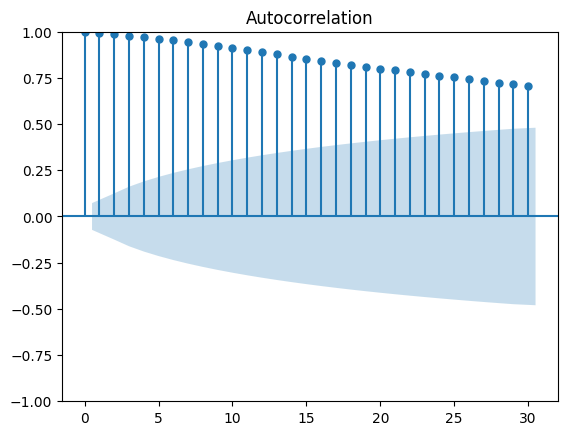

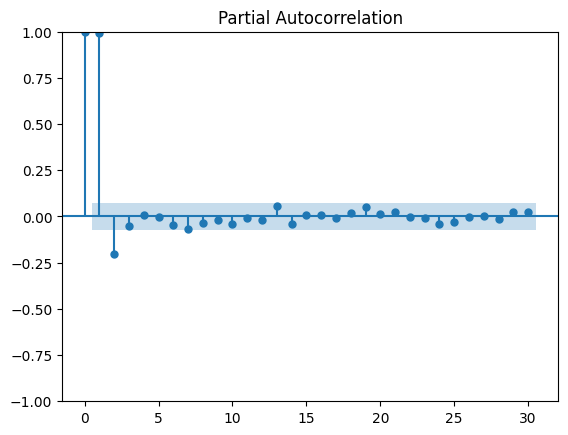

In [484]:
#NOT STATIONARY
#FIND ARIMA PARAMETERS
plot_acf(df['Revenue'], lags=30)
plot_pacf(df['Revenue'], lags=30)
plt.show()

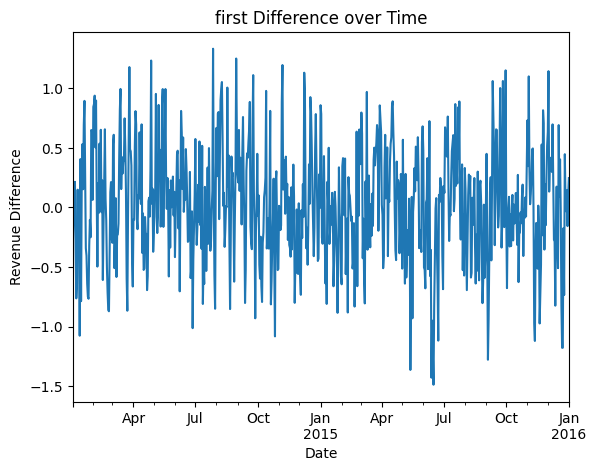

,Revenue
Date,
2014-01-01,0.000000
2014-01-02,-0.292356
2014-01-03,-0.327772
2014-01-04,-0.339987
2014-01-05,-0.124888


In [485]:
#MODEL NEEDS TO BE STATIONARY FOR EFFICIENCY
#Differencing
diff = df['Revenue'].diff().dropna()
diff.plot()
plt.title('first Difference over Time')
plt.ylabel('Revenue Difference')
plt.show()
df.head()

In [486]:
#AUGMENTED DICKEY-FULLER TEST
#CHECKING FOR STATIONARITY
adf_test = adfuller(diff)
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -17.374772
p-value: 0.000000


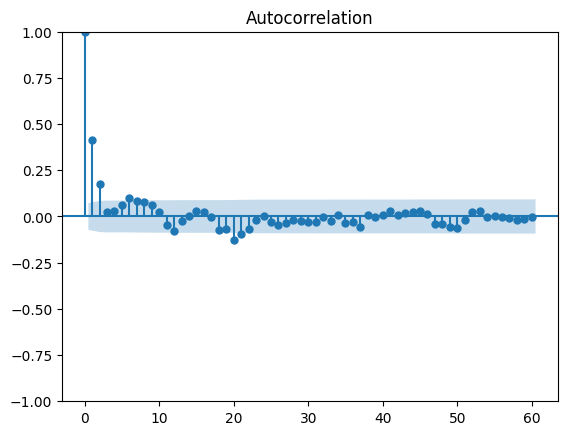

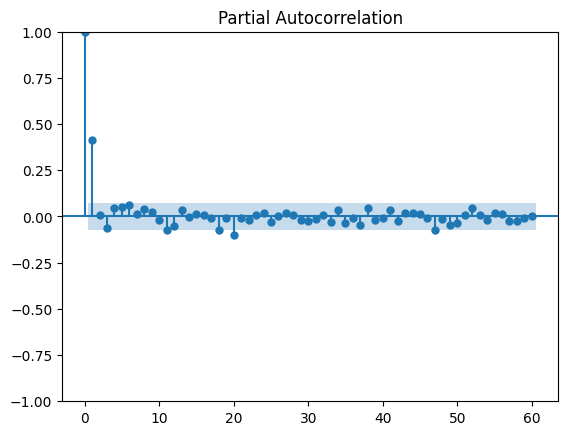

In [487]:
#FIND ARIMA PARAMETERS
plot_acf(diff, lags=60)
plot_pacf(diff, lags=60)
plt.show()

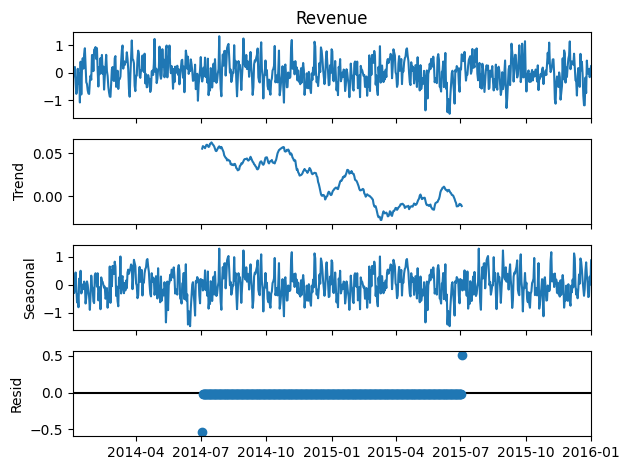

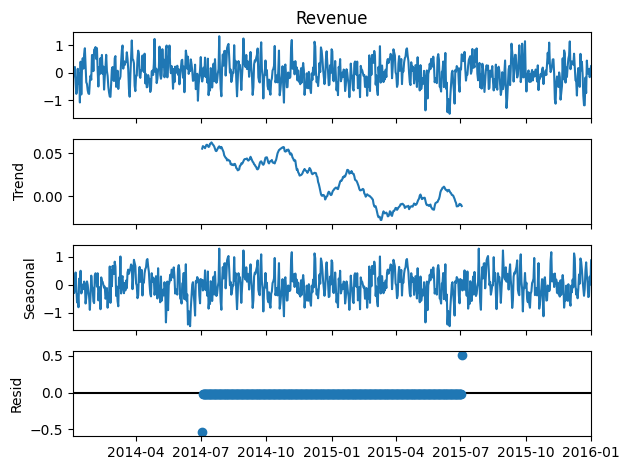

In [488]:
decomposition = seasonal_decompose(diff, model='additive', period=365)  # for daily data
decomposition.plot()

In [489]:
df_cleaned = diff.copy()
df_cleaned.to_csv("C:/Users/tyler/OneDrive - SNHU/WGU/Machine Learning/Task3/cleaned_data.csv", index=False)
print(df_cleaned.head())

Date
2014-01-02   -0.292356
2014-01-03   -0.035416
2014-01-04   -0.012215
2014-01-05    0.215100
2014-01-06   -0.366702
Freq: D, Name: Revenue, dtype: float64


In [490]:
#split data
train_size = int(len(diff) * 0.8)
train, test = diff[0:train_size], diff[train_size:]
print(f'Training Data: {len(train)} samples')
print(f'Test Data: {len(test)} samples')

Training Data: 584 samples
Test Data: 146 samples


In [491]:
model = ARIMA(diff, order=(0,0,2))
model_fit=model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  730
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -435.826
Date:                Thu, 06 Mar 2025   AIC                            879.651
Time:                        18:51:24   BIC                            898.023
Sample:                    01-02-2014   HQIC                           886.739
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0220      0.026      0.839      0.402      -0.029       0.073
ma.L1          0.4072      0.036     11.408      0.000       0.337       0.477
ma.L2          0.1971      0.036      5.435      0.0

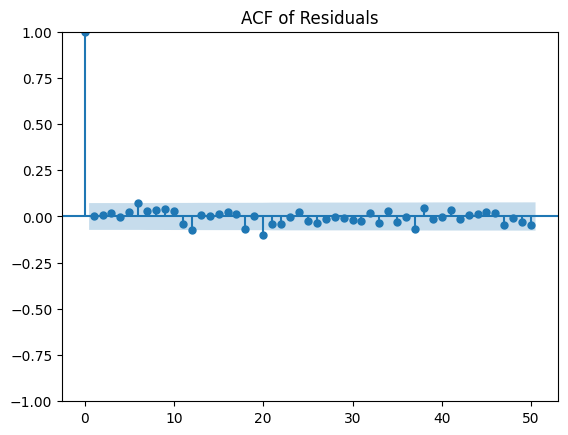

In [492]:
residuals = model_fit.resid

# Plot ACF for residuals
plot_acf(residuals, lags=50)
plt.title("ACF of Residuals")
plt.show()

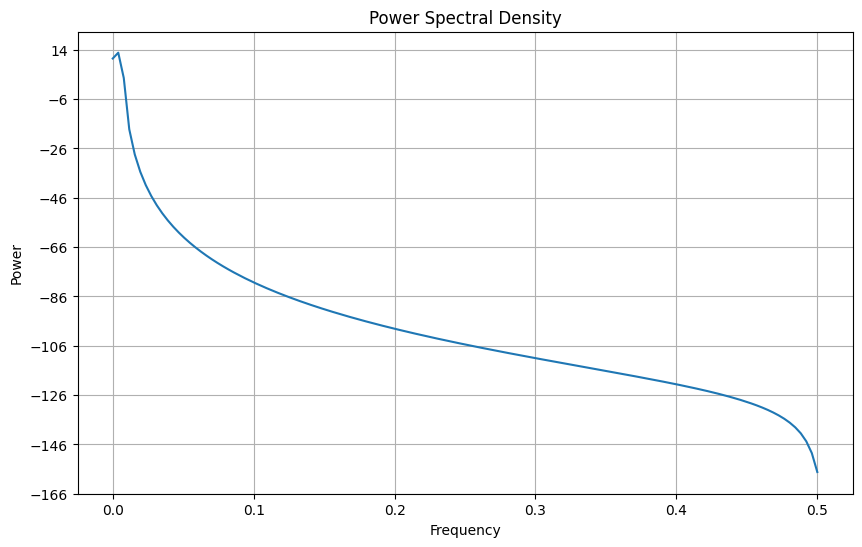

In [493]:
#generate sample signal
fs = 1  #Sampling frequency
days=730
t = np.arange(0,days)  #time
signal = 0.5 * np.sin(2 * np.pi * 1 * t) + 0.5 * np.sin(2 * np.pi * 1/365 * t)  #2 sine waves of frequencies 1 day and 5

plt.figure(figsize=(10, 6))
plt.psd(signal, NFFT=256, Fs=fs, noverlap=128, scale_by_freq=True)
plt.title("Power Spectral Density")
plt.xlabel("Frequency")
plt.ylabel("Power")

# Show the plot
plt.show()


In [494]:
# Forecast for the test period
forecast_steps = len(test)
forecast_results = model_fit.get_forecast(steps=forecast_steps)

# Extract predicted values
pred = forecast_results.predicted_mean
pred.index = test.index
confidence_intervals = forecast_results.conf_int(alpha=0.05)

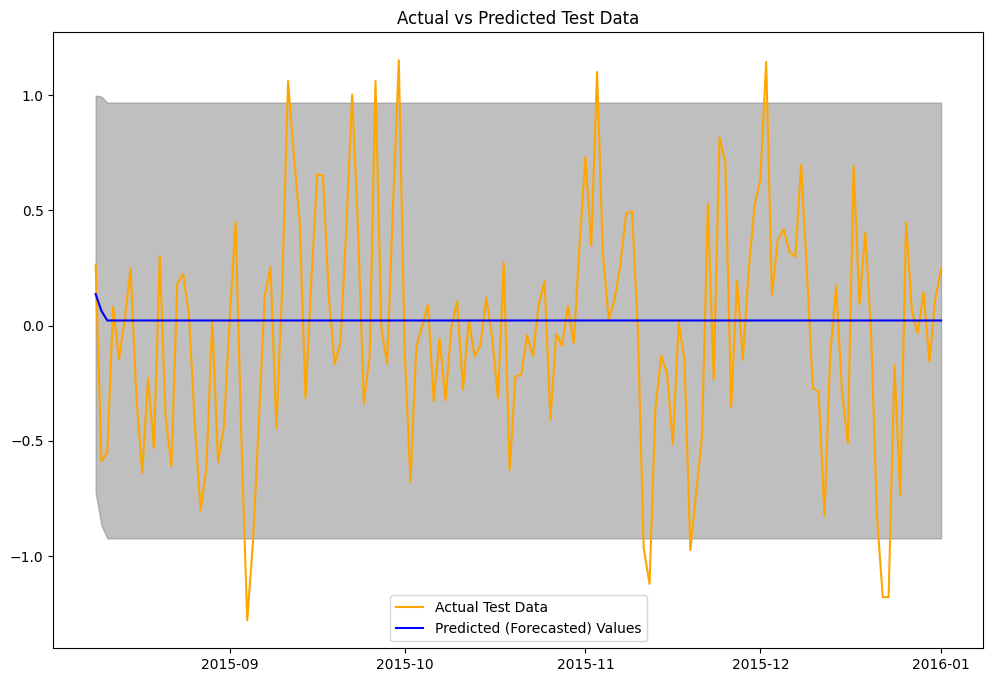

In [495]:
# Plotting the actual vs predicted values
plt.figure(figsize=(12, 8))
plt.plot(test.index, test, label='Actual Test Data', color='orange')
plt.plot(pred.index, pred, label='Predicted (Forecasted) Values', color='blue')
plt.fill_between(pred.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='gray', alpha=0.5)

plt.legend()
plt.title("Actual vs Predicted Test Data")
plt.show()

In [496]:
#align by index
pred = pred.reindex(test.index)

#calculate the accuracy metrics
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.3751043915013413
Root Mean Squared Error (RMSE): 0.48761863531309874


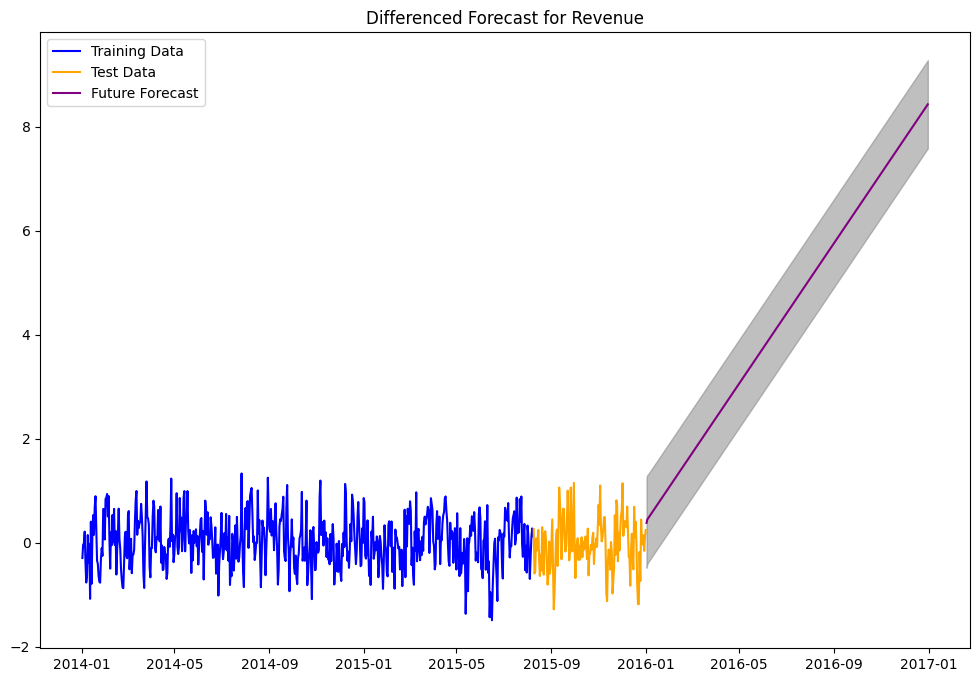

In [497]:
#for future forecasting with confidence intervals:
forecast_periods = 365

# Get forecast
forecast_results = model_fit.get_forecast(steps=forecast_periods)

#Extract the forecasted differences and the confidence intervals
forecast_diff = forecast_results.predicted_mean
confidence_intervals = forecast_results.conf_int(alpha = 0.05)

#Reverse the differencing to get the forecasted values on the original scale
last_value = diff.iloc[-1]
future_values = [last_value]

#Reverse the differencing by cumulatively summing the forecast differences
for i in range(1, len(forecast_diff) + 1):
    future_values.append(future_values[-1] + forecast_diff.iloc[i-1])

#Create a forecast index for future dates
forecast_index_future = pd.date_range(start=df.index[-1], periods=forecast_periods+1, freq='D')[1:]

#Convert the forecasted values into a pandas series
future_values_series = pd.Series(future_values[1:], index=forecast_index_future)

#Calculate the lower and upper bounds for the confidence intervals
lower_bound = future_values_series - (confidence_intervals.iloc[:, 1] - confidence_intervals.iloc[0, 0]) / 2
upper_bound = future_values_series + (confidence_intervals.iloc[:, 1] - confidence_intervals.iloc[0, 0]) / 2

#Ensure no Nulls and set float
lower_bound = lower_bound.ffill().bfill().astype(float)
upper_bound = upper_bound.ffill().bfill().astype(float)

plt.figure(figsize=(12, 8))
# Plot the training data in blue
plt.plot(train.index, train, label='Training Data', color='blue')

# Plot the test data in orange
plt.plot(test.index, test, label='Test Data', color='orange')

# Plot the forecasted values (purple)
plt.plot(future_values_series.index, future_values_series, label='Future Forecast', color='purple')

# Add the confidence interval as a shaded region (gray shadow)
plt.fill_between(future_values_series.index, lower_bound, upper_bound, color='gray', alpha=0.5)

# Add labels and legend
plt.legend()
plt.title("Differenced Forecast for Revenue")
plt.show()

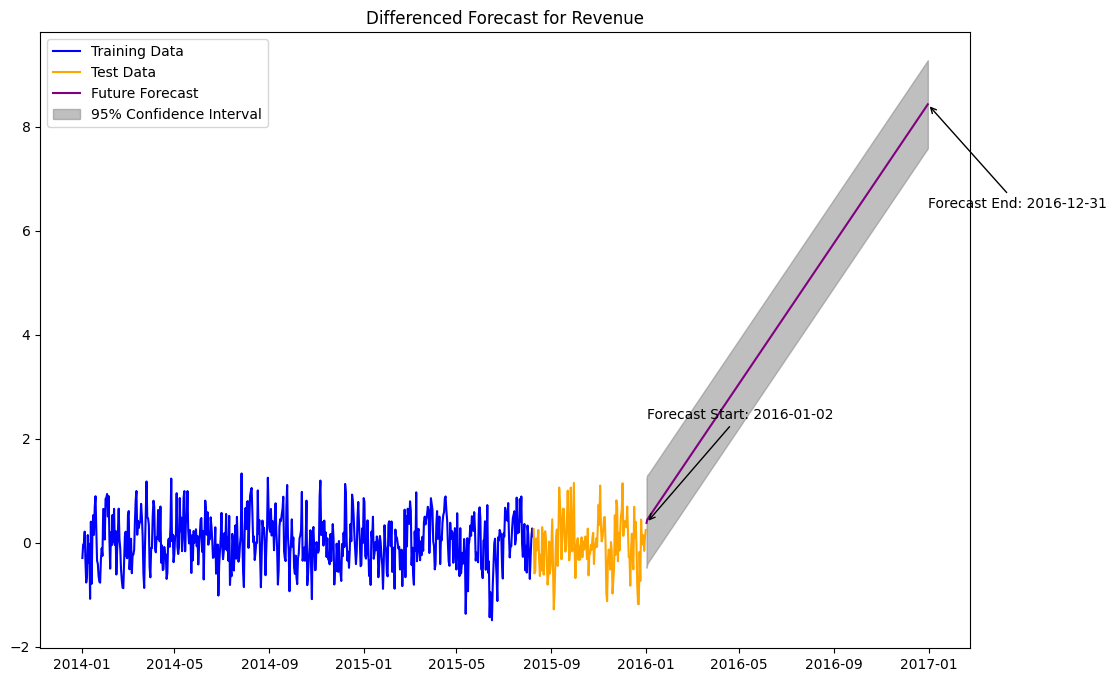

In [498]:
forecast_periods = 365

forecast_results = model_fit.get_forecast(steps=forecast_periods)

# Extract the forecasted differences and the confidence intervals
forecast_diff = forecast_results.predicted_mean
confidence_intervals = forecast_results.conf_int(alpha=0.05)

#reverse the differencing
last_value = diff.iloc[-1]
future_values = [last_value]

#reverse the differencing by cumulatively summing the forecast differences
for i in range(1, len(forecast_diff) + 1):
    future_values.append(future_values[-1] + forecast_diff.iloc[i-1])

#forecast index for future dates
forecast_index_future = pd.date_range(start=df.index[-1], periods=forecast_periods+1, freq='D')[1:]

#convert the forecasted values
future_values_series = pd.Series(future_values[1:], index=forecast_index_future)

#calculate the lower and upper bounds
lower_bound = future_values_series - (confidence_intervals.iloc[:, 1] - confidence_intervals.iloc[0, 0]) / 2
upper_bound = future_values_series + (confidence_intervals.iloc[:, 1] - confidence_intervals.iloc[0, 0]) / 2

#no Nulls
lower_bound = lower_bound.ffill().bfill().astype(float)
upper_bound = upper_bound.ffill().bfill().astype(float)

plt.figure(figsize=(12, 8))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(future_values_series.index, future_values_series, label='Future Forecast', color='purple')
plt.fill_between(future_values_series.index, lower_bound, upper_bound, color='gray', alpha=0.5, label='95% Confidence Interval')
plt.legend()
plt.title("Differenced Forecast for Revenue")

# Annotate important points
plt.annotate(f'Forecast Start: {future_values_series.index[0].date()}', 
             xy=(future_values_series.index[0], future_values_series.iloc[0]),
             xytext=(future_values_series.index[0], future_values_series.iloc[0] + 2), 
             arrowprops=dict(arrowstyle="->", color='black'), fontsize=10)

plt.annotate(f'Forecast End: {future_values_series.index[-1].date()}', 
             xy=(future_values_series.index[-1], future_values_series.iloc[-1]),
             xytext=(future_values_series.index[-1], future_values_series.iloc[-1] - 2), 
             arrowprops=dict(arrowstyle="->", color='black'), fontsize=10)

plt.show()


In [499]:
def dif_inv(diff, first_value):
    series_inverted = np.r_[first_value, diff].cumsum().astype('float64')
    return series_inverted[1:]

print(f"Length of train: {len(train)}")
print(f"Length of test: {len(test)}")
print(f"Length of df: {len(diff)}")

Length of train: 584
Length of test: 146
Length of df: 730


In [500]:
train = dif_inv(train, diff.iloc[0])
test = dif_inv(test, train[-1])

print(f"Length of train: {len(train)}")
print(f"Length of test: {len(test)}")
print(f"Length of df: {len(df)}")

train = pd.Series(train, index=diff.index[:len(train)])  # Assign the train index
test = pd.Series(test, index=diff.index[len(train):len(train)+len(test)])

Length of train: 584
Length of test: 146
Length of df: 731


In [501]:
forecast_steps = len(test)
forecast_results = model_fit.get_forecast(steps=forecast_steps)

#extract predicted values
pred = forecast_results.predicted_mean
pred_inverted = dif_inv(pred, train.iloc[-1])
#ensure the forecast is aligned with the test period
pred_inverted = pd.Series(pred_inverted, index=test.index)

confidence_intervals = forecast_results.conf_int(alpha=0.05)
#invert confidence intervals
lower_inverted = dif_inv(confidence_intervals.iloc[:, 0], train.iloc[-1])
upper_inverted = dif_inv(confidence_intervals.iloc[:, 1], train.iloc[-1])

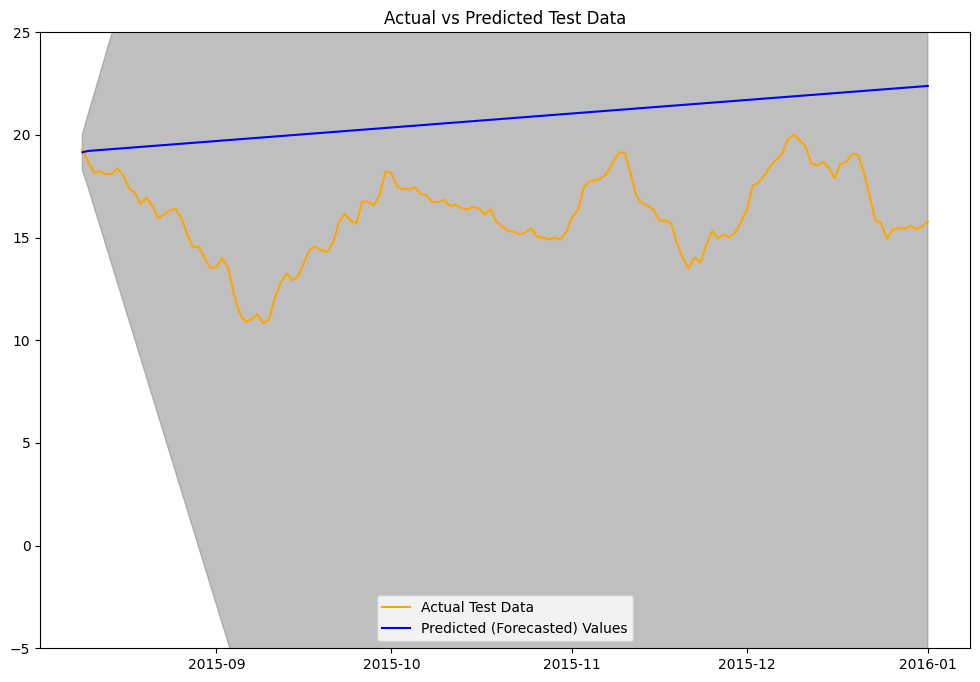

In [502]:
# Plotting the actual vs predicted values
plt.figure(figsize=(12, 8))
plt.plot(test.index, test, label='Actual Test Data', color='orange')
plt.plot(pred_inverted.index, pred_inverted, label='Predicted (Forecasted) Values', color='blue')
plt.fill_between(pred_inverted.index, lower_inverted,  upper_inverted, color='gray', alpha=0.5)
plt.ylim(-5, 25)
plt.legend()
plt.title("Actual vs Predicted Test Data")
plt.show()

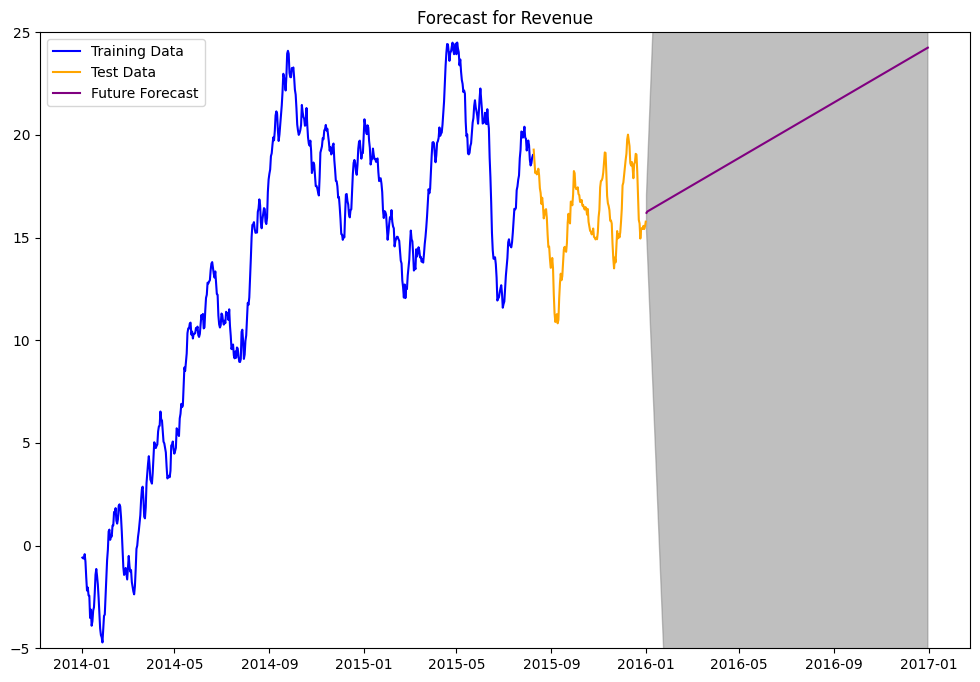

In [503]:
forecast_periods = 365
forecast_results = model_fit.get_forecast(steps=forecast_periods)

#extract the forecasted differences and the confidence intervals
forecast = forecast_results.predicted_mean
confidence_intervals = forecast_results.conf_int(alpha=0.05)

last_value = df.iloc[-1]

future_values = [last_value]

for i in range(len(forecast)):
    future_values.append(future_values[-1] + forecast.iloc[i])

#create a forecast index for future dates
forecast_index_future = pd.date_range(start=df.index[-1], periods=forecast_periods+1, freq='D')[1:]

#convert the forecasted values into a pandas series
future_values_series = pd.Series(future_values[1:], index=forecast_index_future)

#apply inverse differencing to the forecast differences
forecast_series = dif_inv(forecast, last_value)

#calculate the lower and upper bounds
lower_bound = dif_inv(confidence_intervals.iloc[:, 0], last_value)
upper_bound = dif_inv(confidence_intervals.iloc[:, 1], last_value)

# Convert the numpy.ndarray to pandas Series before applying ffill and bfill
lower_bound = pd.Series(lower_bound, index=forecast_index_future)
upper_bound = pd.Series(upper_bound, index=forecast_index_future)

#no Nulls
lower_bound = lower_bound.ffill().bfill().apply(lambda x: float(x) if isinstance(x, (int, float)) else float(x.iloc[0]))
upper_bound = upper_bound.ffill().bfill().apply(lambda x: float(x) if isinstance(x, (int, float)) else float(x.iloc[0]))

plt.figure(figsize=(12, 8))
plt.ylim(-5, 25)
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(future_values_series.index, forecast_series, label='Future Forecast', color='purple')

# Add the confidence interval as a shaded region (gray shadow)
plt.fill_between(future_values_series.index, lower_bound, upper_bound, color='gray', alpha=0.5)

plt.legend()
plt.title("Forecast for Revenue")
plt.show()

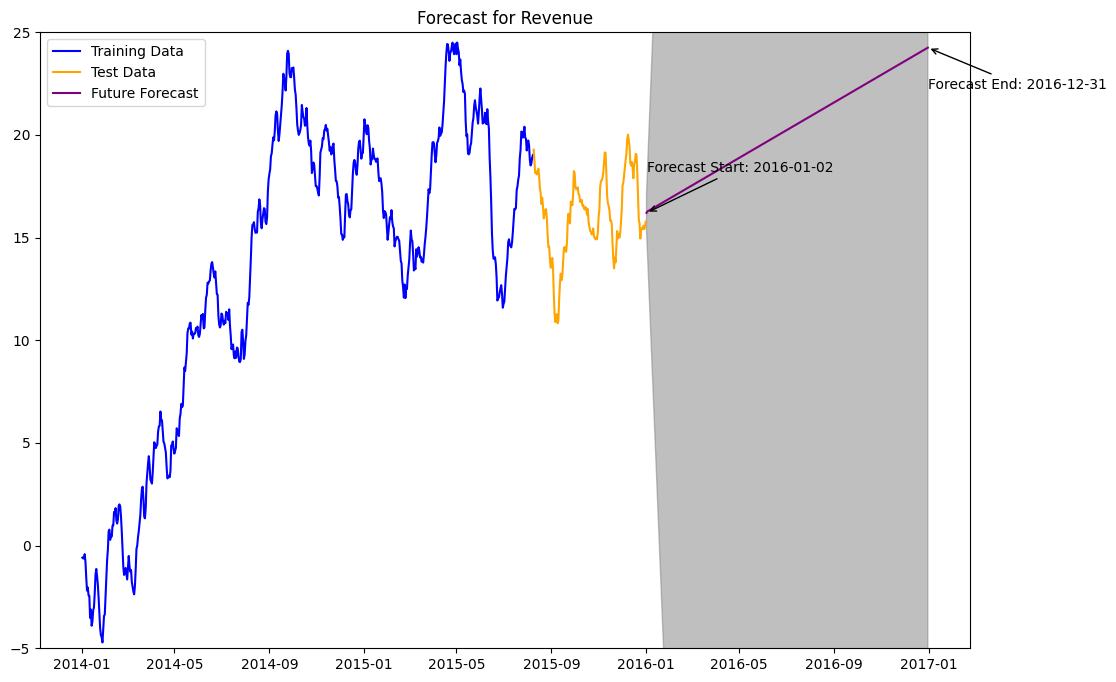

In [504]:
plt.figure(figsize=(12, 8))
plt.ylim(-5, 25)
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(future_values_series.index, forecast_series, label='Future Forecast', color='purple')
plt.fill_between(future_values_series.index, lower_bound, upper_bound, color='gray', alpha=0.5)
plt.legend()
plt.title("Forecast for Revenue")

# Annotate important points (start and end of the forecast period)
# Annotate important points (start and end of the forecast period)
plt.annotate(f'Forecast Start: {future_values_series.index[0].date()}', 
             xy=(future_values_series.index[0], float(future_values_series.iloc[0].item())),
             xytext=(future_values_series.index[0], float(future_values_series.iloc[0].item()) + 2), 
             arrowprops=dict(arrowstyle="->", color='black'), fontsize=10)

plt.annotate(f'Forecast End: {future_values_series.index[-1].date()}', 
             xy=(future_values_series.index[-1], float(future_values_series.iloc[-1].item())),
             xytext=(future_values_series.index[-1], float(future_values_series.iloc[-1].item()) - 2), 
             arrowprops=dict(arrowstyle="->", color='black'), fontsize=10)

plt.show()